Epoch 1/15, Loss: 0.9572, Train Accuracy: 69.72%
Epoch 2/15, Loss: 0.5416, Train Accuracy: 82.32%
Epoch 3/15, Loss: 0.4830, Train Accuracy: 84.16%
Epoch 4/15, Loss: 0.4475, Train Accuracy: 85.37%
Epoch 5/15, Loss: 0.4217, Train Accuracy: 86.35%
Epoch 6/15, Loss: 0.4166, Train Accuracy: 86.69%
Epoch 7/15, Loss: 0.4040, Train Accuracy: 87.08%
Epoch 8/15, Loss: 0.3887, Train Accuracy: 86.94%
Epoch 9/15, Loss: 0.4166, Train Accuracy: 86.28%
Epoch 10/15, Loss: 0.3959, Train Accuracy: 87.24%
Epoch 11/15, Loss: 0.3623, Train Accuracy: 87.74%
Epoch 12/15, Loss: 0.3815, Train Accuracy: 87.37%
Epoch 13/15, Loss: 0.3613, Train Accuracy: 88.10%
Epoch 14/15, Loss: 0.3783, Train Accuracy: 87.67%
Epoch 15/15, Loss: 0.3676, Train Accuracy: 88.37%
Test Accuracy: 85.35%


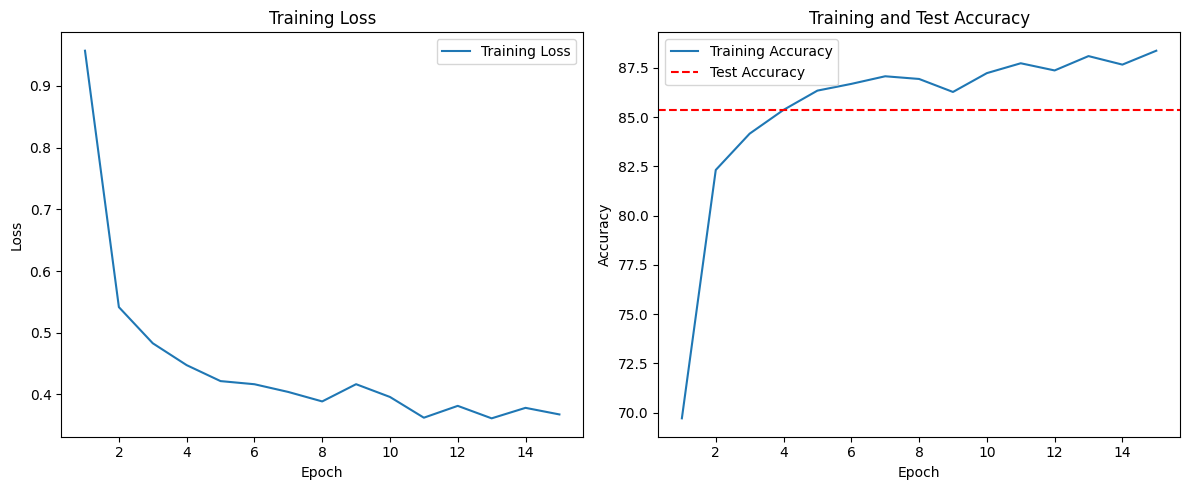

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define data transformations with enhanced augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to your external dataset
dataset_dir = 'D:\\Programs\\Jupyter\\Pest_data'

# Load train and test datasets
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Update the number of classes dynamically based on the dataset
num_classes = len(train_dataset.classes)

# Define the model with improvements
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.size()
        query = self.query(x).view(batch_size, -1, H * W).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, H * W)
        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)

        value = self.value(x).view(batch_size, -1, H * W)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, H, W)

        out = self.gamma * out + x
        return out

class PestIdentificationModel(nn.Module):
    def __init__(self, num_classes):
        super(PestIdentificationModel, self).__init__()
        resnet = models.resnet50(pretrained=True)
        
        # Freeze initial layers for better fine-tuning
        for param in resnet.parameters():
            param.requires_grad = False
        
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])
        self.self_attention = SelfAttention(in_channels=2048)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)  # Dropout to reduce overfitting
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet_features(x)
        x = self.self_attention(x)
        x = self.avg_pool(x).view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = PestIdentificationModel(num_classes=num_classes)
model = model.cuda()  # Move model to GPU

# Define optimizer, loss function, and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Variables to store metrics for plotting
train_accuracies = []
test_accuracies = []
train_losses = []

# Training loop with improvements
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    scheduler.step(avg_loss)

# Test the model
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
test_accuracies.append(test_accuracy)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
plt.axhline(y=test_accuracy, color="r", linestyle="--", label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
